In [1]:
%matplotlib inline  

In [2]:
# system ----
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [3]:
# local ----
simPath = os.path.expanduser("~/_simulations/fire_collab/")
projPath = os.path.expanduser("~/_projects/researchproject_003/")
sys.path.append(simPath)
sys.path.append(projPath+"modules")
import plot_parameters

In [31]:
sys.path.append("../../")
from halo_sample import *
from halo_alpha import *

#print halo_name   
#print halo_mass   
#print halo_rad    
#print star_mass   
#print star_rad    
#print vmax_hyd    
#print vmax_dmo    
#print deltaV2_hyd 
#print deltaV2_dmo 
#print rpow2000    
#print rpow0200    
#print abund       

***

<div class="alert alert-info">
    <font size="6">
<b>
    Inner Slope Parameter 1: $\alpha\ [1-2\%]R_{\rm vir}$
        </b> 
        </font>
</div>

We can plot the fits done in previous studies:

[Di - Cintio et al. 2014](https://arxiv.org/pdf/1306.0898.pdf):
\begin{align}
\alpha_{\rm DC14}(X) = n - \log_{10}\left[\left(\frac{X}{x_{0}}\right)^{-\beta} + \left(\frac{X}{x_{0}}\right)^{\gamma}\right]
\end{align}
where $X = M_{\star}/M_{\rm halo}$ and $\beta$ ($\gamma$) is the low (high) star forming efficiency slope.

[Tollet et al. 2016](https://arxiv.org/pdf/1507.03590.pdf):
\begin{align}
\alpha_{\rm T16}(X) = n - \log_{10}\left[n_{1}\left(1 + \frac{X}{x_{1}}\right)^{-\beta} + \left(\frac{X}{x_{0}}\right)^{\gamma}\right]
\end{align}
where $X = M_{\star}/M_{\rm halo}$ and $\beta$ ($\gamma$) is the low (high) star forming efficiency slope.

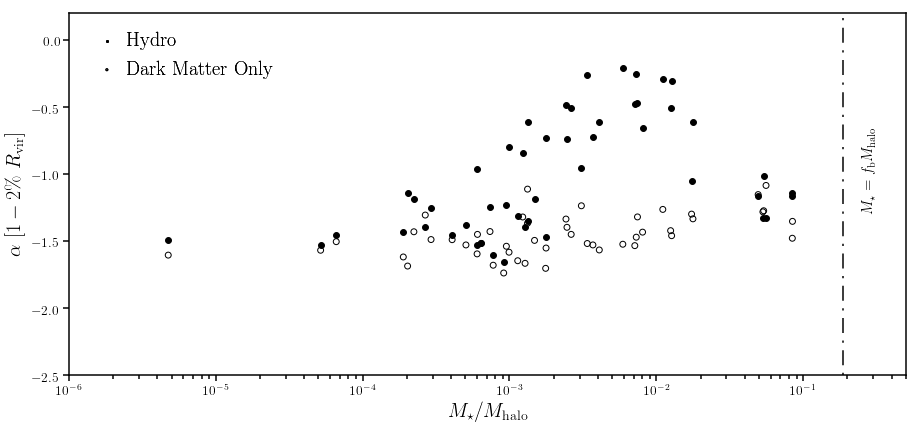

In [109]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], alpha_hyd[halo], marker='o', s=35, color='black', zorder=1)
    ax.scatter(abund[halo], alpha_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
# Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), -0.75, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

ax.scatter(-5,-5, color='black',label=r'$\rm Hydro$')
ax.scatter(-5,-5, edgecolor='black', facecolor='None', label=r'$\rm Dark\ Matter\ Only$')
scatter_leg = ax.legend(loc="upper left", fontsize=20, scatterpoints=1, frameon=False, fancybox=True, shadow=True,       handletextpad=0.01)
ax.add_artist(scatter_leg)

ax.set_xscale('log')
 
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(-2.5,0.2)
 
ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$", fontsize=20)
ax.set_ylabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$", fontsize=20)

plt.show()

## We can plot the fits done in previous studies:

### [**Di - Cintio et al. 2014**](https://arxiv.org/pdf/1306.0898.pdf):
\begin{align}
\alpha_{\rm DC14}(X) = n - \log_{10}\left[\left(\frac{X}{x_{0}}\right)^{-\beta} + \left(\frac{X}{x_{0}}\right)^{\gamma}\right]
\end{align}
where $X = M_{\star}/M_{\rm halo}$ and $\beta$ ($\gamma$) is the low (high) star forming efficiency slope.

\left\{ n, n_{1}, x_{0}, x_{1}, \beta, \gamma \right\}
For $M_{\star}/M_{\rm halo}$
\begin{align}
n = 0.132,\ x_{0} = 10^{-2.051},\ \beta = 0.593,\ \gamma = 1.99 
\end{align}



### [**Tollet et al. 2016**](https://arxiv.org/pdf/1507.03590.pdf):
\begin{align}
\alpha_{\rm T16}(X) = n - \log_{10}\left[n_{1}\left(1 + \frac{X}{x_{1}}\right)^{-\beta} + \left(\frac{X}{x_{0}}\right)^{\gamma}\right]
\end{align}
where $X = M_{\star}/M_{\rm halo}$ and $\beta$ ($\gamma$) is the low (high) star forming efficiency slope.

For $M_{\star}/M_{\rm halo}$
\begin{align}
n=-0.158,\ n_{1}=26.49,\ x_{0}=8.77 \times 10^{-3},\ x_{1} = 9.44 \times 10^{-5},\ \beta=0.85,\ \gamma=1.66
\end{align}

In [112]:
# ---- fits
def dicintio_alpha(X,n,logx0,beta,gamma):
    x0 = 10**logx0
    A = np.power(X/x0,-beta) + np.power(X/x0,gamma)
    return n - np.log10(A)
 
def tollet_alpha(X,n,n1,x0,x1,beta,gamma):
    A = n1*np.power(1 + X/x1, -beta)
    B = np.power(X/x0,gamma)
    return n - np.log10(A + B)

tollet_params = [-0.158, 26.49, 8.77e-3, 9.44e-5, 0.85, 1.66]

We would also like to capture the shape of our distribution too. Let us use Tollets' Fitting form

In [167]:
xdat1 = []
ydat1 = []
for halo in halo_name:
    xdat1.append(abund[halo])
    ydat1.append(alpha_hyd[halo])
    
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m

guess = tollet_params
min_bound = [-2, 0, 0, 0, 0, 0]
max_bound = [0, 1, f_b, f_b, 5, 5]
bounds = (min_bound, max_bound)
tollet_fit, tollet_cov = curve_fit(tollet_alpha, xdat1, ydat1, bounds=bounds)

n, n1, x0, x1, beta, gamma = tollet_fit[:]
print 'n     =', tollet_fit[0]
print 'n1    =', tollet_fit[1]
print 'x0    =', tollet_fit[2]
print 'x1    =', tollet_fit[3]
print 'beta  =', tollet_fit[4]
print 'gamma =', tollet_fit[5]

n     = -1.5577094261276643
n1    = 0.8919577909052983
x0    = 0.1489650409091066
x1    = 0.0058392917382459365
beta  = 4.999999999999921
gamma = 0.9688052379589153


This gives us the following fitting parameters
\begin{align}
n = -1.558,\ n_{1} = 0.892,\ x_{0} = 0.149,\ x_{1} = 5.84 \times 10^{-3},\ \beta = 5,\ \gamma = 0.969
\end{align}

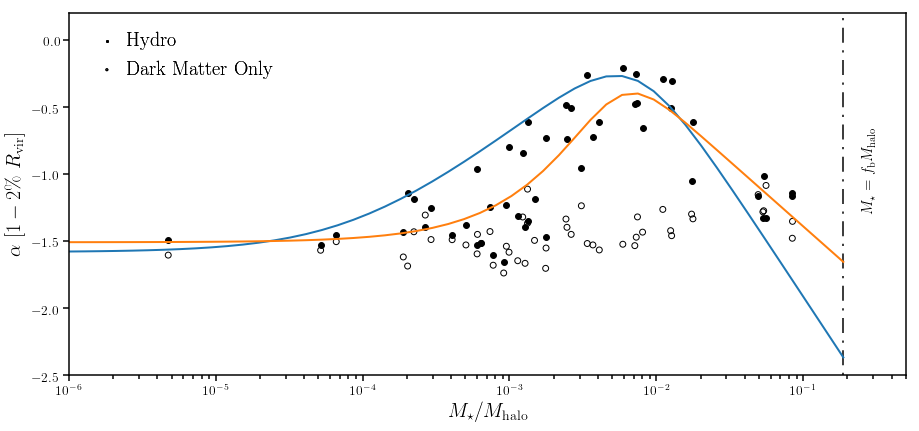

In [168]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

# plot data points
for halo in halo_name:
    ax.scatter(abund[halo], alpha_hyd[halo], marker='o', s=35, color='black', zorder=1)
    ax.scatter(abund[halo], alpha_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
# Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), -0.75, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

# plot curve quess
X = 10**np.linspace(-6, np.log10(f_b), 50)
ax.plot(X, tollet_alpha(X, *tollet_params))
ax.plot(X, tollet_alpha(X, *tollet_fit))


# plot legends
ax.scatter(-5,-5, color='black',label=r'$\rm Hydro$')
ax.scatter(-5,-5, edgecolor='black', facecolor='None', label=r'$\rm Dark\ Matter\ Only$')
scatter_leg = ax.legend(loc="upper left", fontsize=20, scatterpoints=1, frameon=False, fancybox=True, shadow=True,       handletextpad=0.01)
ax.add_artist(scatter_leg)

ax.set_xscale('log')
 
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(-2.5,0.2)
 
ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$", fontsize=20)
ax.set_ylabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$", fontsize=20)

plt.show()

<div class="alert alert-danger">
    <font size="5">
<b>
    Dispersion from $M_{\star}/M_{\rm halo} \sim 10^{-3} - 10^{-2}$
        </b> 
        </font>
</div>

Constant dispersion does not seem to be enough, since a lot of scatter is present at $M_{\star}/M_{\rm halo} \sim 10^{-3} - 10^{-2}$.

In [169]:
alpha1 = []
x1 = []
for halo in halo_name:
    x1.append(abund[halo])
    alpha1.append(alpha_hyd[halo])
    
# ---- Hydro Bin Sampling
#X = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
X_bin = np.array([3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1])
X_ = []
Y_ = []
for i in range(X_bin.size):
    if(i == 0):
        w = np.where(x1 < X_bin[i])[0]
        y = np.array(alpha1)[w]
        X_.append(X_bin[i])
        Y_.append(np.std(y))
    else:
        w = np.where((X_bin[i-1] < x1) & (x1 < X_bin[i]))[0]
        y = np.array(alpha1)[w]
        X_.append(X_bin[i])
        Y_.append(np.std(y))
X_ = np.array(X_)
Y_ = np.array(Y_)

# ---- fill cubic spline ----
# disclaimer, had to add and slightly shift points to have spline behave properly
nX_ = [1e-6, 3e-6, 1.e-5, 3.e-05, 1.e-04, 3.e-04, 1.e-03, 3.e-03, 8.e-3, 1.e-02, 3.e-02, 1.e-01, 1.5e-1, f_b]
nY_ = [0.11969238, 0.11969238, 0.11969238, 0.11969238, 0.11969238, 0.11969238, 0.27367451, 0.35326899, 0.1599472, 
       0.1599472, 0.1599472, 0.1599472, 0.13492734, 0.13492734]

nY = tollet_alpha(np.array(nX_), *tollet_fit)
Yup = nY + np.array(nY_)
Ydo = nY - np.array(nY_)
X__ = 10**np.linspace(np.log10(min(nX_)), np.log10(f_b), 100)

from scipy.interpolate import UnivariateSpline
splup = UnivariateSpline(nX_, Yup, k=2, s=0)
spldo = UnivariateSpline(nX_, Ydo, k=2, s=0)

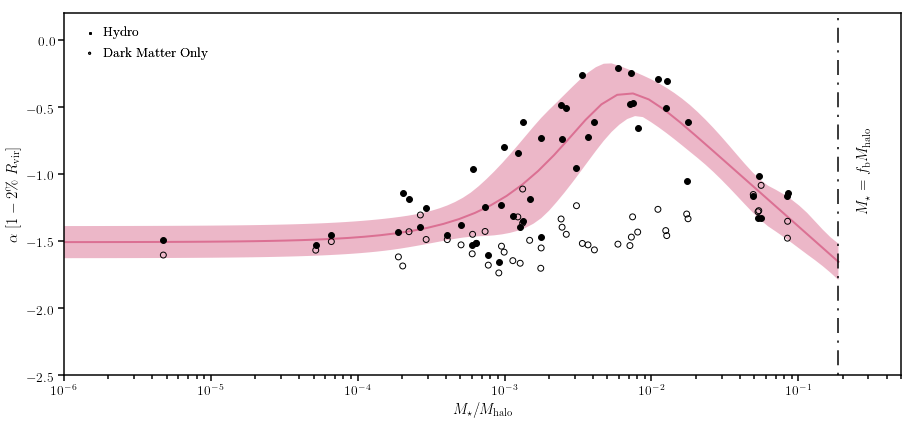

In [170]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], alpha_hyd[halo], marker='o', s=35, color='black', zorder=1)
    ax.scatter(abund[halo], alpha_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
# ---- Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), -0.75, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

# ---- Plotting Fitting Functions 
X = 10**np.linspace(np.log10(1e-6), np.log10(f_b))
# My Fit w/ binned scatter 
Y = tollet_alpha(X, *tollet_fit)
ax.plot(X, Y, c=color1, ls='-', zorder=0)
ax.fill_between(X__, splup(X__), spldo(X__), facecolor=color1, edgecolor="None", alpha=0.5, zorder=0)

ax.scatter(-5,-5, color='black',label=r'$\rm Hydro$')
ax.scatter(-5,-5, edgecolor='black', facecolor='None', label=r'$\rm Dark\ Matter\ Only$')
scatter_leg = ax.legend(loc="upper left", fontsize=13.5, scatterpoints=1, frameon=False, fancybox=True, shadow=True,handletextpad=0.01)
ax.add_artist(scatter_leg)

ax.set_xscale('log')
 
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(-2.5,0.2)
 
ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$")
ax.set_ylabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$")

plt.show()

## The Master Plot

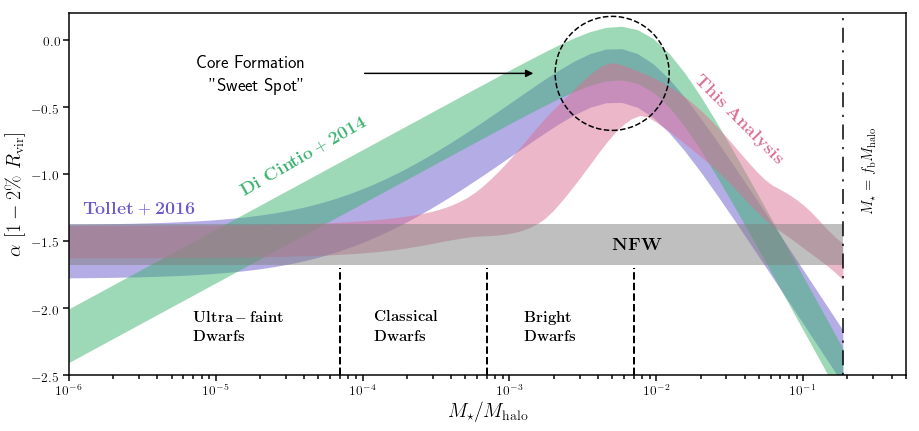

In [171]:
color1 = 'palevioletred'
color2 = 'slateblue'
color3 = 'mediumseagreen'
 
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)
    
# Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), -0.75, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

# ---- Tollet Fit
X = 10**np.linspace(np.log10(1e-6), np.log10(f_b))
Y = tollet_alpha(X,-0.158,26.49,8.77e-3,9.44e-5,0.85,1.66)
#ax.plot(X, Y, c='black', ls='-', zorder=0)
ax.fill_between(X, Y+0.20, Y-0.20, facecolor=color2, edgecolor="None", alpha=0.5, zorder=0)
ax.text(1.25e-6, -1.3  , r'$\bf Tollet+2016$', color=color2, rotation=0, fontsize=18)
 
# ---- Di Cintio Fit
Y = dicintio_alpha(X,0.132,-2.051,0.593,1.99)
#ax.plot(X, Y, c='black', ls='--', zorder=0)
ax.fill_between(X, Y+0.20, Y-0.20, facecolor=color3, edgecolor="None", alpha=0.5, zorder=0)
ax.text(1.4e-5, -0.65  , r'$\bf Di\ Cintio+2014$', color=color3, rotation=30, zorder=2, fontsize=18)
 
# ---- My Fit w/ binned scatter
# ---- constant scatter
Y = tollet_alpha(X, *tollet_fit)
ax.fill_between(X__, splup(X__), spldo(X__), facecolor=color1, edgecolor="None", alpha=0.5, zorder=0)
ax.text(1.75e-2, -0.33  , r'$\bf This\ Analysis$', color=color1, rotation=-45, fontsize=18)

# ---- Plotting Sweet Spot
ax.scatter(5e-3, -0.25, s=13000, facecolor="None", edgecolor='black', linestyle="--", linewidth=1.5)
ax.annotate('', xy=(1.5e-3, -0.25), xytext=(1e-4, -0.25), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.text(0.75e-5, -0.21, 'Core Formation', color='black', fontsize=18)
ax.text(0.9e-5, -0.38, '"Sweet Spot"', color='black', fontsize=18)

'''
# ---- Plotting alpha bands
ax.text(1.5e-6, -0.25, r'$\rm  Core$', fontsize=20)
ax.text(1.5e-6, -0.525, r'$\rm  Mild\ Cusp$', fontsize=20)
ax.text(1.5e-6, -0.775, r'$\rm  Cusp$', fontsize=20)
ax.axhspan(-0.3,0.2, facecolor="black", edgecolor="None",alpha=0.3, zorder=0)
ax.axhspan(-0.6,-0.3, facecolor="black", edgecolor="None", alpha=0.2, zorder=0)
#ax.axhspan(-2.5,-0.6, facecolor="gray", edgecolor="None", alpha=0.1)
'''
 
# ---- Plotting NFW bands
ax.fill_between(X, -1.375, -1.675, facecolor='gray', edgecolor="None", alpha=0.5, zorder=0)
ax.text(5e-3, -1.575  , r'$\bf NFW$', color='black', rotation=0, fontsize=18)

# ---- Plotting dwarf bands
# Ultra faints
#ax.text(2e-5, -1.75, r'$\rm Ultra-faint$', rotation=90)
ax.text(7e-6, -2.1  , r'$\bf Ultra-faint$')
ax.text(7e-6, -2.25, r'$\bf Dwarfs$')
ax.plot(np.linspace(7e-5,7e-5), np.linspace(-2.5, -1.7), linewidth=2., ls='--', color='black')
# Classical Dwarfs
ax.text(1.2e-4, -2.1  , r'$\bf Classical$')
ax.text(1.2e-4, -2.25, r'$\bf Dwarfs$')
ax.plot(np.linspace(7e-4,7e-4), np.linspace(-2.5, -1.7), linewidth=2., ls='--', color='black')
# Bright Dwarfs
ax.text(1.25e-3, -2.1  , r'$\bf Bright$')
ax.text(1.25e-3, -2.25, r'$\bf Dwarfs$')
ax.plot(np.linspace(7e-3,7e-3), np.linspace(-2.5, -1.7), linewidth=2., ls='--', color='black')

ax.set_xscale('log')
 
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(-2.5,0.2)
 
ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$", fontsize=20)
ax.set_ylabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$", fontsize=20)

plt.show()

***

***

***

<div class="alert alert-success">
    <font size="6">
<b>A New Fit for $\alpha(x)$</b> 
        </font>
</div>

We want to do better however... and clear misconceptions on the chosen free parameters above.

### Consider the following assumptions

* Let $X = M_{\star}/M_{\rm halo}$

* As $X \longrightarrow 0$ we must have $\alpha \longrightarrow \alpha_{\rm NFW} \approx -1.5$ such that
\begin{align}
\alpha(X=0) = \alpha_{\rm NFW} 
\end{align}

* It then leads me to propose two functions that model this behavior function that becomes zero as $X \longrightarrow 0$
\begin{align}
\alpha(X) = \alpha_{\rm NFW} \pm \log_{10}\left[ 1 + f(X) \right]
\end{align}
where $f(x) \rightarrow 0$ as $X \rightarrow 0$. We can also consider
\begin{align}
\alpha(X) = \alpha_{\rm NFW}\left[ 1 - \tanh (f(X)) \right]
\end{align}
where again where $f(x) \rightarrow 0$ as $X \rightarrow 0$, leading to $\tanh \rightarrow 0 $



* It starts to become less of a NFW at $10^{4} < X < 10^{-3}$ until $X \approx 8 
\times 10^{-2}$

* We start with
\begin{align}
\alpha(X) = \alpha_{\rm NFW}\left[ 1 - \tanh \left(\frac{X}{x_{\rm peak}} \right) \right]
\end{align}

In [187]:
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m

def lazar_alpha(X, aNFW, x0):
    return aNFW*(1. - np.tanh((X/x0))**2. )

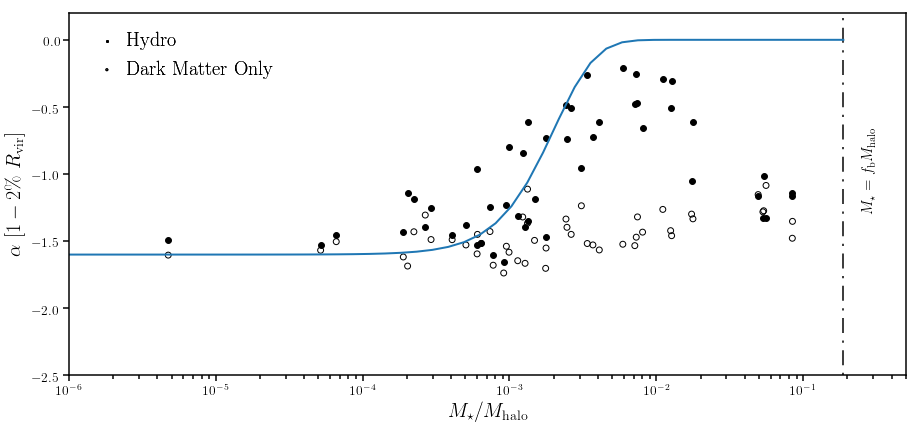

In [188]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], alpha_hyd[halo], marker='o', s=35, color='black', zorder=1)
    ax.scatter(abund[halo], alpha_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
# Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), -0.75, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

X = 10**np.linspace(np.log10(1e-6), np.log10(f_b))
aNFW = -1.6
x0 = 2e-3
ax.plot(X, lazar_alpha(X, aNFW, x0))

ax.scatter(-5,-5, color='black',label=r'$\rm Hydro$')
ax.scatter(-5,-5, edgecolor='black', facecolor='None', label=r'$\rm Dark\ Matter\ Only$')
scatter_leg = ax.legend(loc="upper left", fontsize=20, scatterpoints=1, frameon=False, fancybox=True, shadow=True,       handletextpad=0.01)
ax.add_artist(scatter_leg)

ax.set_xscale('log')
 
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(-2.5,0.2)
 
ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$", fontsize=20)
ax.set_ylabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$", fontsize=20)

plt.show()

***

***

***

<div class="alert alert-info">
    <font size="6">
<b>
    Inner Slope Parameter 2: $\rho_{\rm hydro}/\rho_{\rm dmo}\ [500\ \rm pc]$
        </b> 
        </font>
</div>

### How well does this compare to the definition of $\alpha$?

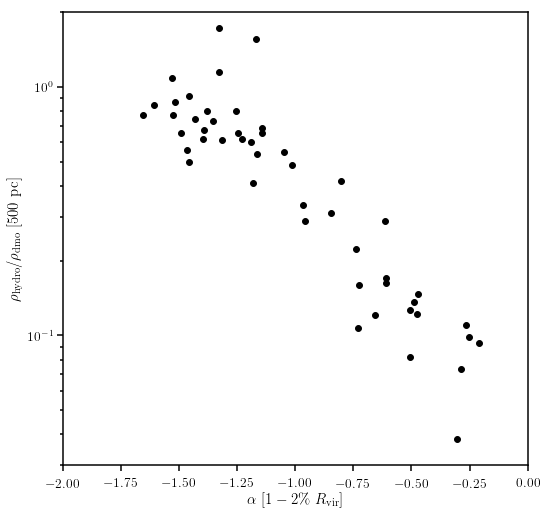

In [17]:
fig = plt.figure(figsize=(10/1.2, 10/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(alpha_hyd[halo], ratio500pc[halo], marker='o', s=35, color='black', zorder=1)

ax.set_yscale('log')
 
ax.set_xlim(-2.,0.)
ax.set_ylim(3e-2, 2)
 
ax.set_xlabel(r"$\alpha\ [1-2\%\ R_{\rm vir}]$")
ax.set_ylabel(r"$\rho_{\rm hydro}/ \rho_{\rm dmo}\ [500\ \rm pc]$")

plt.show()

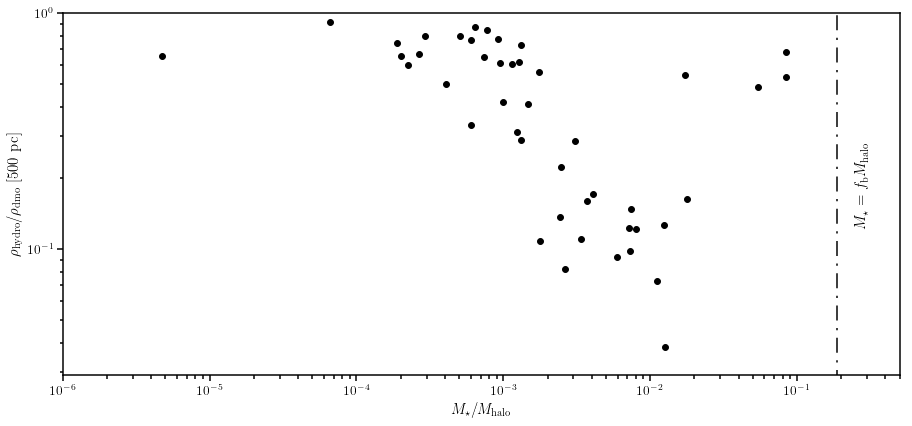

In [161]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], ratio500pc[halo], marker='o', s=35, color='black', zorder=1)
    
# ---- Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(-2.5, 1.5)
ax.text(np.power(10.,-0.6), 0.25, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(0, 1)

ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$")
ax.set_ylabel(r"$\rho_{\rm hydro}/ \rho_{\rm dmo}\ [500\ \rm pc]$")

plt.show()

***

***

***

<div class="alert alert-info">
    <font size="6">
<b>
    Inner Slope Parameter 3: $\Delta_{V/2}$  
        </b> 
        </font>
</div>

### Defined by [Alam, Bullock, and Weinberg](https://iopscience.iop.org/article/10.1086/340190/fulltext/54852.text.html)

As a measure of central density, we adopt the quantity $\Delta_{V/2}$, the density within the radius $R_{V/2}$ at which the halo rotation curve falls to half of its maximum value, in units of the critical density:
\begin{align}
\Delta_{V/2} &:= \frac{\rho(r_{\rm V/2})}{\rho_{\rm crit}} \\
&= \frac{1}{2}\left( \frac{V_{\rm max}}{H_{0} R_{V/2}} \right)^{2}
\end{align}

The concentration parameters are defined in terms of specific density profiles, but they can be related to the general parameters $R_{V/2}, \Delta_{V/2},$ and $V_{\rm max}$. For a NFW
\begin{align}
\Delta_{V/2} &= 409 \frac{c^{3}}{f(c)} \\
R_{V/2} &= 0.13 r_{s} \\
V_{\rm max}^{2} &\simeq 0.2 V_{\rm vir}^{2} \frac{c}{f(c)} \\
\end{align}
where $f(c) = \log(1+c) - c/(1+c)$

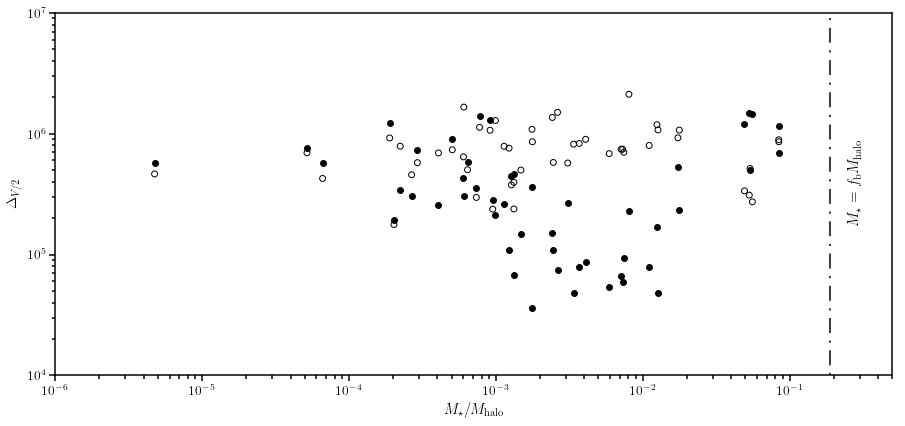

In [162]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], deltaV2_hyd[halo], marker='o', s=35, color='black', zorder=1)
    ax.scatter(abund[halo], deltaV2_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
# Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m
fbx = np.linspace(f_b, f_b)
fby = np.linspace(1e+4, 1e+7)
ax.text(np.power(10.,-0.6), 7e+5, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(1e+4, 1e+7)

ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$")
ax.set_ylabel(r"$\Delta_{V/2}$")

plt.show()

## Fit Assumptions for $\Delta_{V/2, \rm Lazar}$</font>:

* We want normalized component to be $\Delta_{V/2, \rm NFW} \sim 10^{6}$
* Dependence on $X = M_{\star}/M_{\rm halo}$

\begin{align}
\log_{10}\Delta_{V/2, \rm Lazar}(X) = \log_{10}\Delta_{\rm NFW} - \log_{10}\left[n_{1}\left(1 + \frac{X}{x_{1}}\right)^{-\beta} + \left(\frac{X}{x_{0}}\right)^{\gamma}\right]
\end{align}
where $\Delta_{\rm NFW} \equiv \Delta_{V/2, \rm NFW}$.

In [201]:
def dV2_func(X, dNFW, n1, x0, x1, beta, gamma):
    A = np.power(1. -  X/x1, -beta) 
    B = n1 * np.power(X/x0, gamma)
    return 10**(np.log10(dNFW) - np.log10(A + B))

In [207]:
xdat = []
ydat = []
for halo in halo_name:
    xdat.append(abund[halo])
    ydat.append(deltaV2_hyd[halo])
min_bound = [7e+5, 0, 0, 0, 0, 0]
max_bound = [2e+6, np.inf, np.inf, np.inf, 5, 5]
bounds = (min_bound, max_bound)
dV2_fit, dV2_cov = curve_fit(dV2_func, xdat, ydat, bounds=bounds)

print dV2_fit[0]
print dV2_fit[1]
print dV2_fit[2]
print dV2_fit[3]
print dV2_fit[4]
print dV2_fit[5]

700000.0000000001
4127.2110335910575
6698.332510789531
1260.071528932258
1.1875180614892606e-10
3.4662627067158445


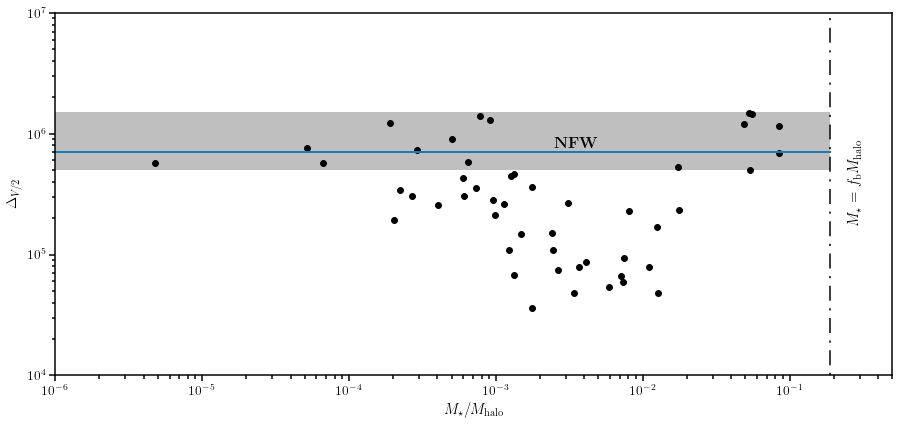

In [205]:
fig = plt.figure(figsize=(18/1.2, 8/1.2))
ax = fig.add_subplot(111)

for halo in halo_name:
    ax.scatter(abund[halo], deltaV2_hyd[halo], marker='o', s=35, color='black', zorder=1)
    #ax.scatter(abund[halo], deltaV2_dmo[halo], marker='o', s=35, facecolor="None", edgecolor='black', zorder=1)
    
X = 10**np.linspace(np.log10(1e-6), np.log10(f_b))
ax.plot(X, dV2_func(X, *dV2_fit))

# ---- Cosmic baryonic fraction
omega0m = 0.266
omega0b = 0.0499
f_b = omega0b/omega0m

fbx = np.linspace(f_b, f_b)
fby = np.linspace(1e+4, 1e+7)
ax.text(np.power(10.,-0.6), 7e+5, r'$M_{\star} = f_{\rm b} M_{\rm halo}$', rotation=90)
ax.plot(fbx, fby, linewidth=1.5, dashes=[1.5,5, 10, 5], color='black')

# ---- Plotting NFW bands
ax.fill_between(X, 1.5e+6, 5e+5, facecolor='gray', edgecolor="None", alpha=0.5, zorder=0)
ax.text(2.5e-3, 7.5e+5  , r'$\bf NFW$', color='black', rotation=0, fontsize=16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-6, 5e-1)
ax.set_ylim(1e+4, 1e+7)

ax.set_xlabel(r"$M_{\star}/M_{\rm halo}$")
ax.set_ylabel(r"$\Delta_{V/2}$")

plt.show()